In [85]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import pandas as pd
import numpy as np

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from os import listdir
import pickle

In [211]:
def check_data(images,labels):  
    '''
    Checking number of total images and labels to make sure they are the same
    Print the number of class images for jindo and shiba (class imbalance)
    Print the plots of 9 images
    '''
    #find all indexes with a value of 0 and use the first value of the returned tuple
    #taking the length gives the number of indexes with value 0
    num_jindo = len(np.where(labels == 0)[0]) 
    num_shiba = len(np.where(labels == 1)[0])
    
    diff = abs(num_jindo-num_shiba)
    
    print('Number of images: {} and labels: {}'.format(len(images), len(labels)))
    print('Number of Jindo images: {}, Number of Shiba images: {}'.format(num_jindo,num_shiba))
    if num_jindo != num_shiba:
        print('Class is imbalanced by: {}'.format(diff))
    
    #plot with matplotlib    
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow((images[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
    plt.show()

In [172]:
def pickle_save(model,name):
    '''
    saving models with pickle
    '''
    full_name = name + '.pickle'
    with open(full_name, 'wb') as f:
        pickle.dump(model, f)

In [4]:
!pwd

/Users/Rich/Desktop/Flatiron/Final/breed-classifcation


In [296]:
# get all the data in the directory split/test, and reshape them
data_all = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary'
) 

images, labels = next(data_all)

Found 532 images belonging to 2 classes.


Number of images: 532 and labels: 532
Number of Jindo images: 245, Number of Shiba images: 287
Class is imbalanced by: 42


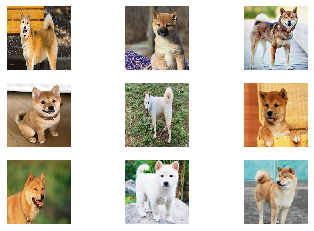

In [297]:
plt.axis('off')
check_data(images,labels)

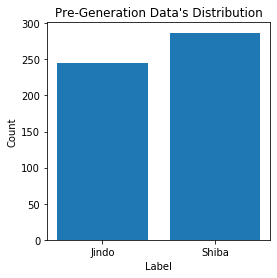

In [298]:
fig, ax = plt.subplots(figsize = (4,4))

#find all indexes with a value of 0 and use the first value of the returned tuple
#taking the length gives the number of indexes with value 0
num_jindo = len(np.where(labels == 0)[0]) 
num_shiba = len(np.where(labels == 1)[0])

ax.bar(['Jindo','Shiba'],[num_jindo,num_shiba])
plt.title('Pre-Generation Data\'s Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

# Data Augmentation
Since I have only 250 and 300 images of each class (the typical amount of data needed for CNNs are usually 1,000 per class) I decided to use offline augmentation to make my dataset bigger.
The first 3 generations are on both classes and the last is to address the class imbalance.

#### 3 Image generators on both classes

In [299]:
img_gen1 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=-20,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generatation_1 = img_gen1.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary'
) 

images_gen1, labels_gen1 = next(data_generatation_1)

Found 532 images belonging to 2 classes.


In [300]:
img_gen2 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=-20,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generatation_2 = img_gen2.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary'
) 
images_gen2, labels_gen2 = next(data_generatation_2)

Found 532 images belonging to 2 classes.


In [301]:
img_gen3 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40,
                             width_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generation_3 = img_gen3.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary'
)

images_gen3, labels_gen3 = next(data_generation_3)

Found 532 images belonging to 2 classes.


In [302]:
#combine results of the generation
images = np.concatenate([images,images_gen1,images_gen2,images_gen3])
labels = np.concatenate([labels,labels_gen1,labels_gen2,labels_gen3])

Number of images: 2128 and labels: 2128
Number of Jindo images: 980, Number of Shiba images: 1148
Class is imbalanced by: 168


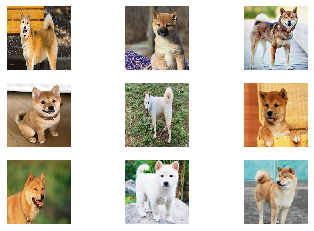

In [303]:
check_data(images,labels)

#### Class Balancing
Note: Rather than class balancing, there may be an option to use 3 augmentations and weights or try smote again

In [162]:
#final image generation for balancing classes. Current best unbalanced model is cnn3
img_gen4 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=30,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              shear_range=0.2,
#                              zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generation_4 = img_gen4.flow_from_directory( 
        './data/', 
        target_size=(224, 224), 
        batch_size = 168,  #class differences
        classes = ['jindo'],
        class_mode = 'binary'
)

images_gen4, labels_gen4 = next(data_generation_4)

Found 245 images belonging to 1 classes.


Number of images: 168 and labels: 168
Number of Jindo images: 168, Number of Shiba images: 0
Class is imbalanced by: 168


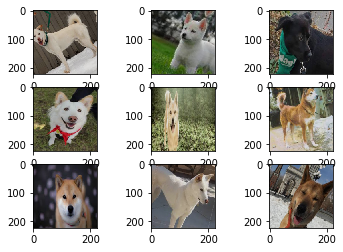

In [165]:
#check to make sure we generated the right amount of data.
check_data(images_gen4,labels_gen4)

In [166]:
#Add the jindo generated data to prior data 
final_images = np.concatenate([images,images_gen4])
final_labels = np.concatenate([labels,labels_gen4])

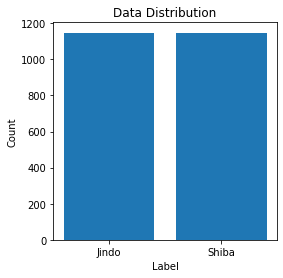

In [167]:
#plot
fig, ax = plt.subplots(figsize = (4,4))

ax.bar(['Jindo','Shiba'],[num_jindo,num_shiba])

plt.title('Balanced Final Data\'s Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

### Train Test Split

In [168]:
#split data into model set and test set
X_model, X_test, y_model, y_test = train_test_split(final_images, final-labels, test_size=0.20, random_state=123)

In [169]:
#split model set into train and testing
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [170]:
labels[:5] , labels[-5:]

(array([0., 1., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32))

In [171]:
X_train.shape

(1468, 224, 224, 3)

# CNN with Unbalanced Data:

In [173]:
cnn = models.Sequential()

#feature learning
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
# cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
# cnn.add(layers.MaxPooling2D((2, 2)))

#classification
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

<b> CNN model 1</b>



In [174]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 715s 487ms/step - loss: 1.3276 - acc: 0.5068 - val_loss: 0.6980 - val_acc: 0.4783
Epoch 2/5
1468/1468 [==============================] - 489s 333ms/step - loss: 0.6870 - acc: 0.5906 - val_loss: 0.6907 - val_acc: 0.5571
Epoch 3/5
1468/1468 [==============================] - 402s 274ms/step - loss: 0.6832 - acc: 0.6124 - val_loss: 0.6738 - val_acc: 0.5652
Epoch 4/5
1468/1468 [==============================] - 427s 291ms/step - loss: 0.6603 - acc: 0.6117 - val_loss: 0.6736 - val_acc: 0.5679
Epoch 5/5
1468/1468 [==============================] - 423s 288ms/step - loss: 0.6237 - acc: 0.6703 - val_loss: 0.6248 - val_acc: 0.6630


In [79]:
# results_train = cnn.evaluate(X_train, y_train)
# results_test = cnn.evaluate(X_test, y_test)
# print(results_train, results_test)

#results
#[0.6924256106902813, 0.568965494632721] [0.6936018729428632, 0.4587155878543854]

109/109 [==============================] - 3s 27ms/step
[0.6924256106902813, 0.568965494632721] [0.6936018729428632, 0.4587155878543854]


In [80]:
# predictions = cnn.predict(X_test)
# predictions = np.around(predictions)

In [81]:
# confusion_matrix(y_test, predictions)

# array([[ 0, 59],
#        [ 0, 50]])

array([[ 0, 59],
       [ 0, 50]])

# Thoughts

The model is just predicting everything to be a shibas. By predicting one class, the accuracy is consistently either 0.57 or 0.43 depending on which the set has more of which is shown in all of the epochs.



Something is definitely wrong and it may be:
1. Not enough data, usually you would want 1000 images for each class while here I only have 550 for 2 classes. need to do some data augmentation
2. Bad data, not uniform images.
3. Slight class imbalance, which may be fixed from data augmenting

---

<b>CNN 2:</b>

2 layer sets, epoch = 5, batch = 100

In [ ]:
cnn = models.Sequential()

#feature learning
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
# cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
# cnn.add(layers.MaxPooling2D((2, 2)))

#classification
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
cnn2 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=100,
                    validation_data=(X_val, y_val))

In [24]:
# results_train = cnn.evaluate(X_train, y_train)
# results_test = cnn.evaluate(X_test, y_test)
# print(results_train, results_test)

#[0.5308362055490509, 0.7487142086029053] [0.6035305355356333, 0.6924882531166077]

426/426 [==============================] - 19s 44ms/step
[0.5308362055490509, 0.7487142086029053] [0.6035305355356333, 0.6924882531166077]


In [27]:
# predictions = cnn.predict(X_test)
# predictions = np.around(predictions)

In [28]:
# confusion_matrix(y_test, predictions)

array([[145,  52],
       [ 79, 150]])

In [38]:
# pickle_save(cnn,'cnn2(base)')

# Notes

CNN Base Model with one layer, params {epochs: 10,batch: 50}
1. Model is over fit from the accuracy being test,train being 0.548,0.532
2. Moreover the this model is just predicting everything to be a shiba, which is just a bad model. The next steps are to add more data through data augmentation

CNN 2 with 2 layers, params {epoch = 5, batch = 100}:
1. Model is still slightly over fit but an increase it batch size was not bad

#### CNN 3 (best unbalanced)

In [ ]:
cnn3 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=200,
                    validation_data=(X_val, y_val))

In [40]:
results_train_3 = cnn.evaluate(X_train, y_train)
results_test_3 = cnn.evaluate(X_test, y_test)
print(results_train_3, results_test_3)

predictions3 = cnn.predict(X_test)
predictions3 = np.around(predictions)

confusion_matrix(y_test, predictions3)

#[0.3654047561033433, 0.8530492186546326] [0.5881827963349965, 0.7112675905227661]

426/426 [==============================] - 18s 42ms/step
[0.3654047561033433, 0.8530492186546326] [0.5881827963349965, 0.7112675905227661]


array([[122,  75],
       [ 48, 181]])

In [41]:
pickle_save(cnn,'cnn3')

---

# CNN with balanced classes

In [306]:
cnn_bal = models.Sequential()

#feature learning
cnn_bal.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn_bal.add(layers.MaxPooling2D((2, 2)))
cnn_bal.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_bal.add(layers.MaxPooling2D((2, 2)))

#classification
cnn_bal.add(layers.Flatten())
cnn_bal.add(layers.Dense(32, activation='relu'))
cnn_bal.add(layers.Dense(1, activation='sigmoid'))

cnn_bal.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

#### CNN_balanced 1(BEST MODEL)

In [307]:
cnn_bal1 = cnn_bal.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=200,
                    validation_data=(X_val, y_val))
#the model is getting better and better. More epochs may make it very good

Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 918s 626ms/step - loss: 1.3949 - acc: 0.5232 - val_loss: 0.7006 - val_acc: 0.4647
Epoch 2/5
1468/1468 [==============================] - 813s 554ms/step - loss: 0.6769 - acc: 0.5136 - val_loss: 0.6716 - val_acc: 0.6712
Epoch 3/5
1468/1468 [==============================] - 607s 413ms/step - loss: 0.6333 - acc: 0.6580 - val_loss: 0.6401 - val_acc: 0.6630
Epoch 4/5
1468/1468 [==============================] - 619s 422ms/step - loss: 0.5742 - acc: 0.6996 - val_loss: 0.6265 - val_acc: 0.6902
Epoch 5/5
1468/1468 [==============================] - 520s 354ms/step - loss: 0.5338 - acc: 0.7377 - val_loss: 0.5993 - val_acc: 0.7011


In [308]:
#Batches = 200, epochs = 5
results_train_bal1 = cnn_bal.evaluate(X_train, y_train)
results_test_bal1 = cnn_bal.evaluate(X_test, y_test)
print(results_train_bal1, results_test_bal1)

predictions_bal1 = cnn_bal.predict(X_test)
predictions_bal1 = np.around(predictions_bal1)


print('Test F1: ',f1_score(y_test,predictions_bal1))
confusion_matrix(y_test, predictions_bal1)
[0.5039214641261816, 0.7629427909851074] [0.5869227505248525, 0.689130425453186]


460/460 [==============================] - 32s 69ms/step
[0.5039214641261816, 0.7629427909851074] [0.5869227505248525, 0.689130425453186]
F1:  0.7164835164835165


array([[168,  49],
       [ 80, 163]])

Notes: Cnn_bal1 has is still overfit but not as overfit as other balanced cnn models

In [309]:
pickle_save(cnn_bal1,'cnn_bal1')

#### CNN_Balanced 2

In [310]:
cnn_bal2 = cnn_bal.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 124s 84ms/step - loss: 0.5201 - acc: 0.7623 - val_loss: 0.5953 - val_acc: 0.7011
Epoch 2/5
1468/1468 [==============================] - 93s 63ms/step - loss: 0.4441 - acc: 0.7916 - val_loss: 0.7012 - val_acc: 0.5951
Epoch 3/5
1468/1468 [==============================] - 93s 63ms/step - loss: 0.3976 - acc: 0.8331 - val_loss: 0.6527 - val_acc: 0.6685
Epoch 4/5
1468/1468 [==============================] - 94s 64ms/step - loss: 0.2627 - acc: 0.8944 - val_loss: 0.7388 - val_acc: 0.7228
Epoch 5/5
1468/1468 [==============================] - 100s 68ms/step - loss: 0.1423 - acc: 0.9578 - val_loss: 0.7489 - val_acc: 0.7255


In [311]:
#Batches = 50, epochs = 5
results_train_bal2 = cnn_bal.evaluate(X_train, y_train)
results_test_bal2 = cnn_bal.evaluate(X_test, y_test)
print(results_train_bal2, results_test_bal2)

predictions_bal2 = cnn_bal.predict(X_test)
predictions_bal2 = np.around(predictions_bal2)

print('F1: ',f1_score(y_test,predictions_bal2))
confusion_matrix(y_test, predictions_bal2)

460/460 [==============================] - 16s 34ms/step
[0.09399804428260398, 0.9897820353507996] [0.7020892861096756, 0.7043478488922119]
F1:  0.6991150442477876


array([[166,  51],
       [ 85, 158]])

<b>Testing dropout for dealing with overfit</b>

In [196]:
from keras.layers import Dropout

In [312]:
cnn_withdrop = models.Sequential()

cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

#feature learning
cnn_withdrop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))
cnn_withdrop.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))

#classification
cnn_withdrop.add(layers.Flatten())
cnn_withdrop.add(layers.Dense(32, activation='relu'))
cnn_withdrop.add(layers.Dense(1, activation='sigmoid'))

cnn_withdrop.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [313]:
cnn_dropout = cnn_withdrop.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=260,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 911s 620ms/step - loss: 2.4201 - acc: 0.4598 - val_loss: 0.6977 - val_acc: 0.4647
Epoch 2/5
1468/1468 [==============================] - 784s 534ms/step - loss: 0.7044 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.4212
Epoch 3/5
1468/1468 [==============================] - 767s 522ms/step - loss: 0.6915 - acc: 0.5497 - val_loss: 0.6929 - val_acc: 0.5408
Epoch 4/5
1468/1468 [==============================] - 641s 437ms/step - loss: 0.6931 - acc: 0.5095 - val_loss: 0.6929 - val_acc: 0.5380
Epoch 5/5
1468/1468 [==============================] - 479s 327ms/step - loss: 0.6931 - acc: 0.5048 - val_loss: 0.6929 - val_acc: 0.5380


In [314]:
results_train_dropout = cnn_withdrop.evaluate(X_train, y_train)
results_test_dropout = cnn_withdrop.evaluate(X_test, y_test)
print('Train: ',results_train_dropout[1], ' Test: ',results_test_dropout[1])

predictions_dropout = cnn_withdrop.predict(X_test)
predictions_dropout = np.around(predictions_dropout)

print('F1: ',f1_score(y_test,predictions_dropout))
confusion_matrix(y_test, predictions_dropout)

460/460 [==============================] - 20s 43ms/step
Train:  0.5054495930671692  Test:  0.47608694434165955
F1:  0.0163265306122449


array([[217,   0],
       [241,   2]])

In [315]:
pickle_save(cnn_withdrop,'cnn_dropout')

## To do list in Colab Book:
1. Insert Grid Search
2. Transfer learning

# Visualizations

In [237]:
# get all the data in the directory split/test, and reshape them
data_present = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './data', 
        target_size=(225,225), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary'
) 

images, labels = next(data_present)

Found 532 images belonging to 2 classes.


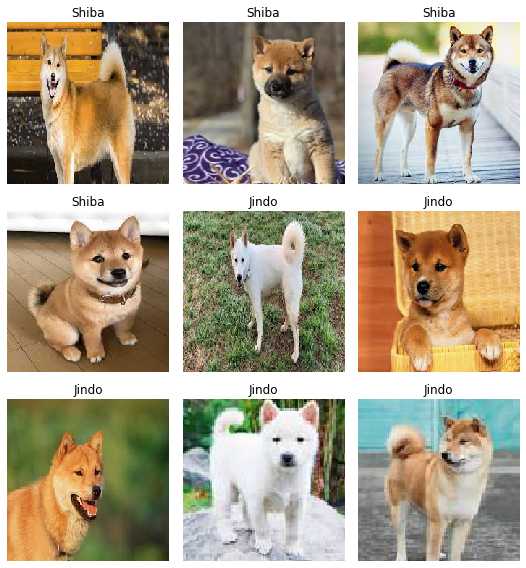

In [350]:
for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplot(330 + 1 + i)
        plt.imshow((images[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)
        if labels[i] == 0:
            class_ = 'Jindo'
        else:
            class_ = 'Shiba'
        plt.title(class_)

plt.tight_layout()
plt.savefig('data_original_collage.png', bbox_inches='tight')        
plt.show()

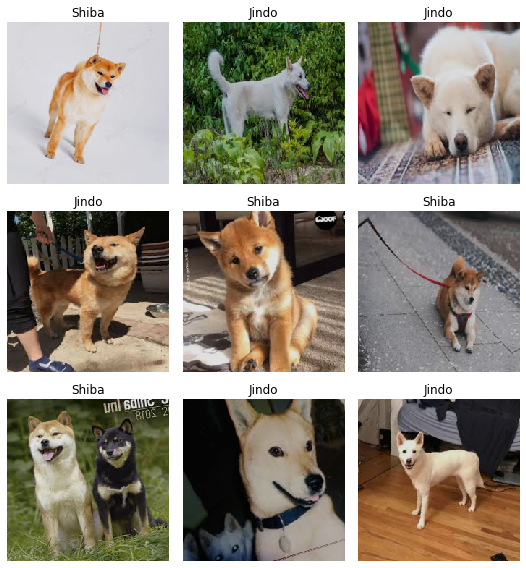

In [349]:
for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplot(330 + 1 + i)
        plt.imshow((images_gen1[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)
        if labels_gen1[i] == 0:
            class_ = 'Jindo'
        else:
            class_ = 'Shiba'
        plt.title(class_)

plt.tight_layout()

plt.savefig('data_augmented.png', bbox_inches='tight')        
plt.show()



In [328]:
import itertools

In [354]:
## Trusty ol' resuable matrix graph code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation = 45)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[[168  49]
 [ 80 163]]


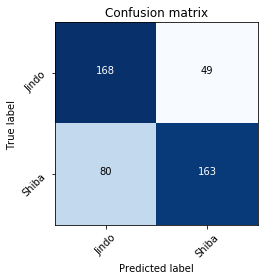

In [355]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ['Jindo','Shiba'], normalize = False)
plt.savefig('confusion_matrix.png')        